In [2]:
import numpy as np 
import pandas as pd 
import pickle
import matplotlib.pyplot as plt
import itertools

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import Adam

from sklearn.metrics import confusion_matrix

dataset = []

with open("./data.pkl","rb") as file:
    dataset = pickle.load(file)
            
trainDataset = dataset["trainDataset"]
testDataset = dataset["testDataset"]

print("Train Size: {} Test Size: {}".format(len(trainDataset), len(testDataset)))

/Users/user2016/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Train Size: 60000 Test Size: 27561


In [3]:
numberOfClass = 10

trainX = [list(td["image"].flatten() / 255) for td in trainDataset]
trainY = np.eye(numberOfClass)[np.array([td["label"] for td in trainDataset]).reshape(-1)] #One-hot encode training labels
testX = [list(td["image"].flatten() / 255) for td in testDataset]
testY = np.eye(numberOfClass)[np.array([td["label"] for td in testDataset]).reshape(-1)] #One-hot encode test labels

In [4]:
print("TrainImageShape:" + str(np.shape(trainX)),
     "TrainLabelShape:" + str(np.shape(trainY)),
     "TestImageShape:" + str(np.shape(testX)),
     "TestLabelShape:" + str(np.shape(testY)))

TrainImageShape:(60000, 784) TrainLabelShape:(60000, 10) TestImageShape:(27561, 784) TestLabelShape:(27561, 10)


In [5]:
trainX = np.reshape(trainX, (np.shape(trainX)[0],28,28,-1))
testX = np.reshape(testX, (np.shape(testX)[0],28,28,-1)) #reshape into 3-dimensional to feed

In [6]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(BatchNormalization())
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
# model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
# model.add(BatchNormalization())
model.add(Dropout(0.3))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
# model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
# model.add(BatchNormalization())
model.add(Dropout(0.3))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 14, 64)        256       
__________

In [7]:
model.compile(optimizer = 'adam' , loss = "categorical_crossentropy", metrics=["accuracy"])

In [8]:
datagen = ImageDataGenerator(
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)


datagen.fit(trainX)

In [9]:
history = model.fit(trainX, trainY, epochs = 1, validation_split= 0.1 ,  # without argumentation
                    shuffle=True, verbose = 2)                                                                       # restrain epoch to run without gpu
# history = model.fit_generator(datagen.flow(trainX,trainY, batch_size=100),  #to run with data argumentation
#                               epochs = 15,
#                               verbose = 2, steps_per_epoch=len(trainX) / 100)

Train on 54000 samples, validate on 6000 samples
Epoch 1/1
 - 429s - loss: 0.0771 - acc: 0.9779 - val_loss: 0.0122 - val_acc: 0.9970


In [10]:
y_predict = model.predict(testX)
y_predict_class = np.argmax(y_predict,axis=1)
y_true = np.argmax(testY,axis=1)

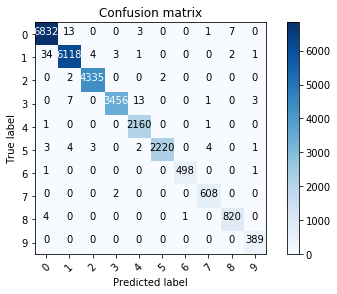

In [11]:
confusion_mtx = confusion_matrix(y_true, y_predict_class)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
plot_confusion_matrix(confusion_mtx, classes=range(numberOfClass))